In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../../")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.linear_model import Lasso

from MAPIE.mapie.classification import MapieClassifier
from MAPIE.mapie.metrics import classification_coverage_score, classification_ssc

# Global variables

In [4]:
PATH_PICKLES = "../../pickle_files"
PATH_IMAGES = "../../"
MLP_MODEL_SCORE = "../../model_weights/mlp_score.pt"
MLP_MODEL_APS = "../../model_weights/mlp_aps.pt"

EMBEDDINGS_FILE = "embeddings.pickle"
SOFTMAX_FILE = "score_softmax.pickle"

RANDOM_STATE = 42

MODEL = "resnet152"

# Get labels and data

In [5]:
def get_labels(path_labels):
    with open(path_labels, 'r') as f:
        content = f.read()
    content = content.split('\n')
    labels = {}
    for l in content :
        labels[l[:9]] = l[9:]

    return labels

labels = get_labels("../../LOC_synset_mapping.txt")

In [6]:
with open(os.path.join(PATH_PICKLES, EMBEDDINGS_FILE), "rb") as f:
    file = pickle.load(f)
    embeddings = file[MODEL]
    image_names = file["image_file"]
with open(os.path.join(PATH_PICKLES, SOFTMAX_FILE), "rb") as f:
    softmax = pickle.load(f)[MODEL]

In [7]:
softmax_list = [arr for arr in softmax]
X_df = pd.DataFrame({"files_name": image_names, "softmax": softmax_list})
labels_keys = list(labels.keys())
y = [labels_keys.index(image_name.split('/')[-2]) for image_name in image_names]

# Plot images for sanity check

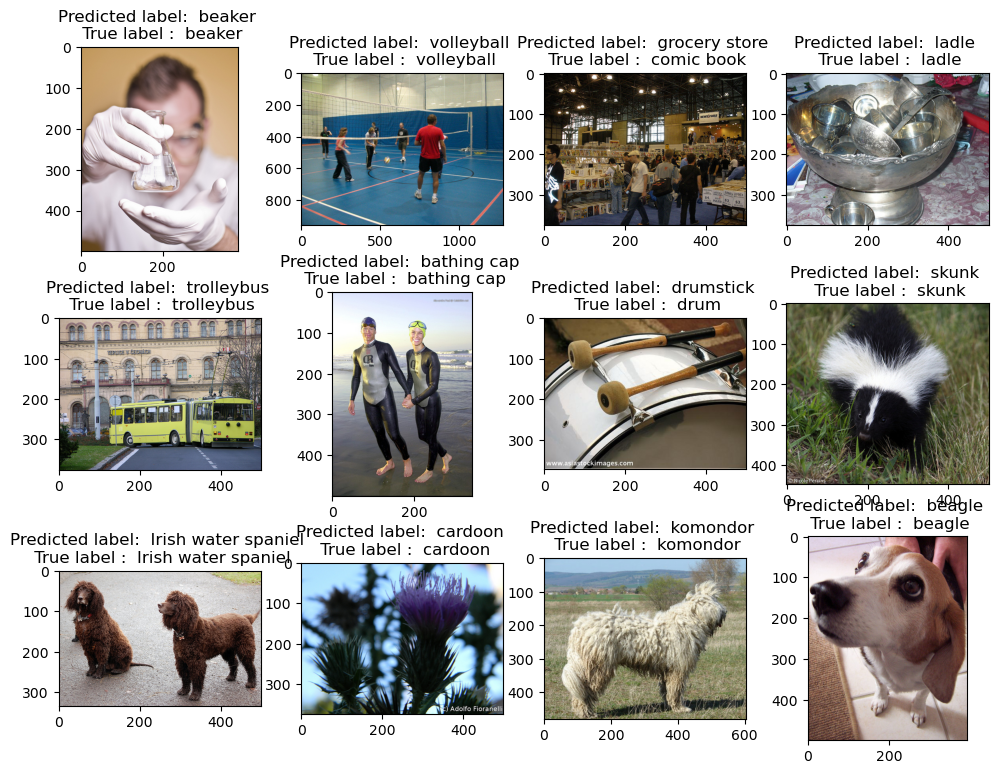

In [8]:
n_rows = 3
n_cols = 4
plot_size = 3

indices_to_plot = random.sample(range(len(image_names)), k=n_rows * n_cols)

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))

count = 0
for i in range(n_rows):
    for j in range(n_cols):
        image_index = indices_to_plot[count]
        image_name = X_df.files_name[image_index]
        image = cv2.imread(
            os.path.join(
                PATH_IMAGES,
                image_name
            )
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = labels[image_name.split('/')[-2]]

        ax[i, j].imshow(image)
        predicted_label_index = np.argmax(X_df.softmax[image_index])
        predicted_label_key = labels_keys[predicted_label_index]
        predicted_label = labels[predicted_label_key]
        title = f"Predicted label: {predicted_label.split(',')[0]} \n True label : {label.split(',')[0]}"
        ax[i, j].set_title(title)
        count += 1 


In [9]:
y_preds = np.argmax(np.vstack(X_df['softmax'].values), axis=1)
global_accuracy_score = accuracy_score(y_true=y, y_pred=y_preds)
print(f'Global accuracy score of the model : {global_accuracy_score:.3f}')

Global accuracy score of the model : 0.823


# Define wrapper class for MAPIE

In [10]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = np.arange(1000)

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = np.argmax(pred_proba, axis=1)
        return pred

    def __sklearn_is_fitted__(self):
        return True

# Define residual regressor

In [11]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(2048, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 64)
        self.layer5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.relu(self.layer1(X))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        out = self.relu(self.layer4(out))
        out = self.relu(self.layer5(out))
        return out

In [12]:
def train_mlp(
        model, X, y,
        optimizer, criterion, n_epochs, patience=5,
        device=torch.device("mps")
):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)
    model.to(device)
    best_val_loss = np.inf
    for epoch in range(n_epochs):
        X_train = torch.Tensor(X_train).to(device)
        y_train = torch.Tensor(y_train).to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val).to(device))
            val_loss = criterion(
                val_outputs,
                torch.tensor(y_val).to(device)
            ).item()
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = model.state_dict()
                print(f'Best model saved at epoch {epoch}/{n_epochs}')
                count_patience = 0
            else:
                count_patience += 1
            
            if count_patience >= patience:
                print('The model stopped improving...')
                break

        print(f'Epoch {epoch}/{n_epochs} - TRAIN_LOSS: {loss.item():.3f} - VALLOSS: {val_loss:.3f}')

    trained_model = model
    trained_model.load_state_dict(best_model_state_dict)
    return trained_model

# Split data into cal, res and test


In [13]:
def split_res_cal_test(X_soft, X_emb, y, y_res):
    X_soft_temp, X_soft_test, y_temp, y_test = train_test_split(X_soft, y, test_size=1/3, random_state=RANDOM_STATE)
    X_emb_temp, X_emb_test, y_res_temp, y_res_test = train_test_split(X_emb, y_res, test_size=1/3, random_state=RANDOM_STATE)

    X_soft_cal, X_soft_res, y_cal, _ = train_test_split(X_soft_temp, y_temp, test_size=.5, random_state=RANDOM_STATE)
    X_emb_cal, X_emb_res, y_res_cal, y_res_res = train_test_split(X_emb_temp, y_res_temp, test_size=.5, random_state=RANDOM_STATE)

    return (
        (X_soft_res["files_name"], X_emb_res, y_res_res),
        (X_emb_cal, y_res_cal),
        (X_soft_cal["files_name"], np.vstack(X_soft_cal["softmax"]), y_cal),
        (X_emb_test, y_res_test),
        (X_soft_test["files_name"], np.vstack(X_soft_test["softmax"]), y_test)
    )

In [14]:
def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=range(1000))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )
    return true_label_cumsum_proba, cutoff + 1

def get_residuals(y_res, y_pred_proba, method):
    if method == "crf_score":
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y_res, axis=1), axis=1
        )
    elif method == "crf_aps":
        cum_sum_proba = _get_true_label_cumsum_proba(y=y_res, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()[:, np.newaxis]
    return y_res_predict_new

In [15]:
y_res_score = get_residuals(y_res=y, y_pred_proba=np.vstack(X_df['softmax'].values), method='crf_score')
y_res_aps = get_residuals(y_res=y, y_pred_proba=np.vstack(X_df['softmax'].values), method='crf_aps')

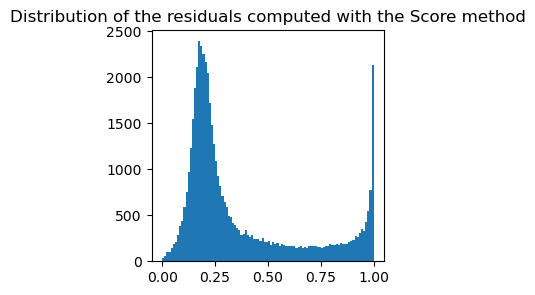

In [16]:
plt.figure(figsize=(3, 3))
plt.hist(y_res_score, bins=100)
plt.title("Distribution of the residuals computed with the Score method")
plt.show()

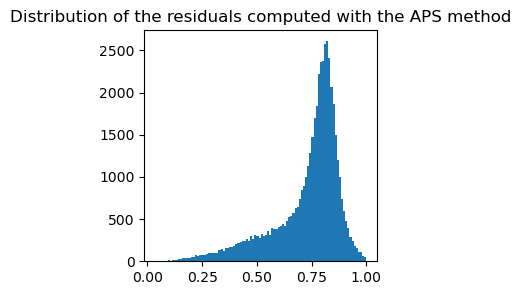

In [17]:
plt.figure(figsize=(3, 3))
plt.hist(y_res_aps, bins=100)
plt.title("Distribution of the residuals computed with the APS method")
plt.show()

In [18]:
(
    (fit_res_filenames, X_fit_res, y_fit_res_score),
    (X_cal_res, y_cal_res_score),
    (cal_filenames, X_cal, y_cal),
    (X_test_res, y_test_res_score),
    (test_filenames, X_test, y_test)
) = split_res_cal_test(X_df, embeddings, y, y_res_score)

In [19]:
(
    (_, _, y_fit_res_aps),
    (_, y_cal_res_aps),
    (_, _, _),
    (_, y_test_res_aps),
    (_, _, _)
) = split_res_cal_test(X_df, embeddings, y, y_res_aps)

In [20]:
assert (y_fit_res_score.shape == y_fit_res_aps.shape)
assert (y_cal_res_score.shape == y_cal_res_aps.shape)
assert (y_test_res_score.shape == y_test_res_aps.shape)

# Check model accuracy on every set

In [21]:
cal_accuracy = accuracy_score(y_true=X_cal.argmax(axis=1), y_pred=y_cal)
test_accuracy = accuracy_score(y_true=X_test.argmax(axis=1), y_pred=y_test)

print(f'Calibration dataset accuracy : {cal_accuracy:.3f}')
print(f'Test dataset accuracy : {test_accuracy:.3f}')

Calibration dataset accuracy : 0.825
Test dataset accuracy : 0.823


# Train residual regressors for Score and APS

## With Neural Network

In [22]:
score_residual_model = MLP()

score_residual_model = train_mlp(
    score_residual_model,
    X_fit_res.astype("float32"),
    y_fit_res_score.astype("float32"),
    optimizer=torch.optim.Adam(score_residual_model.parameters()),
    criterion = nn.MSELoss(),
    n_epochs=100,
    patience=10
)

score_residual_model.cpu()

Best model saved at epoch 0/100
Epoch 0/100 - TRAIN_LOSS: 0.150 - VALLOSS: 0.097
Best model saved at epoch 1/100
Epoch 1/100 - TRAIN_LOSS: 0.097 - VALLOSS: 0.075
Best model saved at epoch 2/100
Epoch 2/100 - TRAIN_LOSS: 0.075 - VALLOSS: 0.064
Best model saved at epoch 3/100
Epoch 3/100 - TRAIN_LOSS: 0.063 - VALLOSS: 0.063
Best model saved at epoch 4/100
Epoch 4/100 - TRAIN_LOSS: 0.063 - VALLOSS: 0.063
Best model saved at epoch 5/100
Epoch 5/100 - TRAIN_LOSS: 0.063 - VALLOSS: 0.059
Epoch 6/100 - TRAIN_LOSS: 0.059 - VALLOSS: 0.060
Epoch 7/100 - TRAIN_LOSS: 0.059 - VALLOSS: 0.059
Best model saved at epoch 8/100
Epoch 8/100 - TRAIN_LOSS: 0.058 - VALLOSS: 0.056
Epoch 9/100 - TRAIN_LOSS: 0.055 - VALLOSS: 0.056
Best model saved at epoch 10/100
Epoch 10/100 - TRAIN_LOSS: 0.056 - VALLOSS: 0.056
Best model saved at epoch 11/100
Epoch 11/100 - TRAIN_LOSS: 0.055 - VALLOSS: 0.055
Best model saved at epoch 12/100
Epoch 12/100 - TRAIN_LOSS: 0.053 - VALLOSS: 0.055
Epoch 13/100 - TRAIN_LOSS: 0.053 - VA

MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
aps_residual_model = MLP()

aps_residual_model = train_mlp(aps_residual_model,
          X_fit_res.astype("float32"),
          y_fit_res_aps.astype("float32"),
          optimizer=torch.optim.Adam(aps_residual_model.parameters()),
          criterion = nn.MSELoss(),
          n_epochs=80,
          patience=10)
aps_residual_model.cpu()

Best model saved at epoch 0/80
Epoch 0/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 1/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 2/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 3/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 4/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 5/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 6/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 7/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 8/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
Epoch 9/80 - TRAIN_LOSS: 0.554 - VALLOSS: 0.559
The model stopped improving...


MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## With RandomForest 

In [38]:
X_train_res, X_val_res, y_train_res_score, y_val_res_score = train_test_split(
    X_fit_res,
    y_fit_res_score,
    test_size=.3,
    random_state=42
)
_, _, y_train_res_aps, y_val_res_aps = train_test_split(
    X_fit_res,
    y_fit_res_aps,
    test_size=.3,
    random_state=42
)

In [39]:
pca = PCA(n_components=150)
X_train_res = pca.fit_transform(X_train_res)

In [40]:
res_score_rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)
res_aps_rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)

res_score_rf.fit(X_train_res, y_train_res_score)
res_aps_rf.fit(X_train_res, y_train_res_aps)

y_score_pred = res_score_rf.predict(pca.transform(X_val_res))
y_aps_pred = res_aps_rf.predict(pca.transform(X_val_res))

print("Random Forest RMSE for SCORE residuals = ", mean_squared_error(y_val_res_score, y_score_pred))
print("Random Forest RMSE for APS residuals = ", mean_squared_error(y_val_res_aps, y_aps_pred))

Random Forest RMSE for SCORE residuals =  0.05653812209589277
Random Forest RMSE for APS residuals =  0.018921993445944203


## With Lasso

In [41]:
lasso_score_rf = Lasso()
lasso_aps_rf = Lasso()

lasso_score_rf.fit(X_train_res, y_train_res_score)
lasso_aps_rf.fit(X_train_res, y_train_res_aps)

y_score_pred = lasso_score_rf.predict(pca.transform(X_val_res))
y_aps_pred = lasso_aps_rf.predict(pca.transform(X_val_res))

print("Lasso RMSE for SCORE residuals = ", mean_squared_error(y_val_res_score, y_score_pred))
print("Lasso RMSE for APS residuals = ", mean_squared_error(y_val_res_aps, y_aps_pred))


Lasso RMSE for SCORE residuals =  0.08146227
Lasso RMSE for APS residuals =  0.024586212


## Analyze results

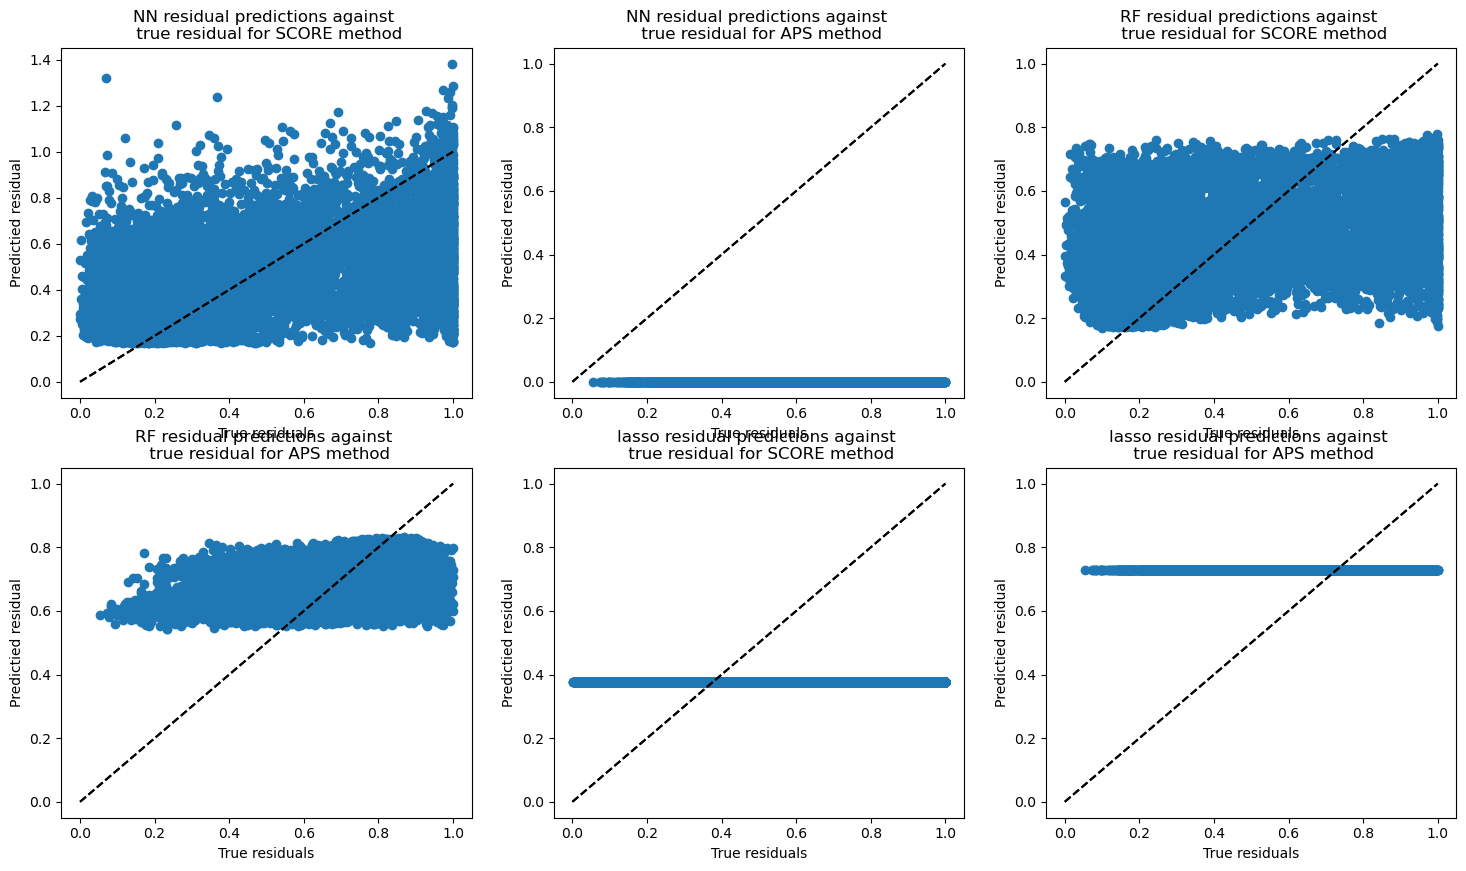

In [42]:
ncols = 3
nrows = 2
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))

nn_score_res_pred = score_residual_model(torch.tensor(X_cal_res.astype("float32")))[:, 0].detach().numpy()
nn_aps_res_pred = aps_residual_model(torch.tensor(X_cal_res.astype("float32")))[:, 0].detach().numpy()

rf_score_res_pred = res_score_rf.predict(pca.transform(X_cal_res))
rf_aps_res_pred = res_aps_rf.predict(pca.transform(X_cal_res))

lasso_score_res_pred = lasso_score_rf.predict(pca.transform(X_cal_res))
lasso_aps_res_pred = lasso_aps_rf.predict(pca.transform(X_cal_res))

for r in range(nrows):
    for c in range(ncols):
        ax[r, c].plot([[0, 0], [1, 1]], linestyle='dashed', c="black")
        ax[r, c].set_xlabel("True residuals")
        ax[r, c].set_ylabel("Predictied residual")


ax[0, 0].scatter(y_cal_res_score, nn_score_res_pred)
ax[0, 1].scatter(y_cal_res_aps, nn_aps_res_pred)
ax[0, 2].scatter(y_cal_res_score, rf_score_res_pred)
ax[1, 0].scatter(y_cal_res_aps, rf_aps_res_pred)
ax[1, 1].scatter(y_cal_res_score, lasso_score_res_pred)
ax[1, 2].scatter(y_cal_res_aps, lasso_aps_res_pred)

ax[0, 0].set_title("NN residual predictions against \n true residual for SCORE method")
ax[0, 1].set_title("NN residual predictions against \n true residual for APS method")
ax[0, 2].set_title("RF residual predictions against \n true residual for SCORE method")
ax[1, 0].set_title("RF residual predictions against \n true residual for APS method")
ax[1, 1].set_title("lasso residual predictions against \n true residual for SCORE method")
ax[1, 2].set_title("lasso residual predictions against \n true residual for APS method")

plt.show()

# MAPIE Calibration

In [112]:
method_params = {
    "score": ("score", True),
    "cumulated_score": ("cumulated_score", True),
    "raps": ("raps", True),
    "crf_score": ("crf_score", True),
    "crf_aps": ("crf_aps", True),
    "ssaps": ("ssaps", True)
}

In [113]:
alphas = np.arange(0.1, 1, .1)
mapie_model = MapieWrapper()
y_preds, y_pss, cal_conformity_scores, cal_residuals, quantiles = {}, {}, {}, {}, {}
for method_name, (method, include_last_label) in method_params.items():
    print("=" * 50)
    print(f'Method: {method_name}')
    mapie = MapieClassifier(mapie_model, method=method, cv="prefit", random_state=42)
    if method in ["crf_score", "ssaps", "crf_aps"]:
        ### Preds on calibration ###
        y_cal_res_pred = score_residual_model(
            torch.tensor(X_cal_res)
        ).detach().numpy()[:, 0]
        
        ### Pred on test ###
        y_test_res_score_pred = score_residual_model(
            torch.tensor(X_test_res)
        ).detach().numpy()[:, 0]

        ### Fit on calibration set ###
        mapie.fit(X_cal, y_cal, residuals=y_cal_res_pred)

        cal_conformity_scores[method_name] = mapie.conformity_scores_
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            X_test,
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_score_pred
        )
        quantiles[method_name] = mapie.quantiles_

    else:   
        mapie.fit(X_cal, y_cal)
        y_preds[method_name], y_pss[method_name] = mapie.predict(X_test, alpha=alphas, include_last_label=include_last_label)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        quantiles[method_name] = mapie.quantiles_

Method: score
Method: cumulated_score
Method: raps
Method: crf_score
[0.43106297 0.18889937 0.3621974  ... 0.2572289  0.48808256 0.17289948]
Method: crf_aps
[0.43106297 0.18889937 0.3621974  ... 0.2572289  0.48808256 0.17289948]
Method: ssaps
[0.43106297 0.18889937 0.3621974  ... 0.2572289  0.48808256 0.17289948]


# Non-conformity scores distributions

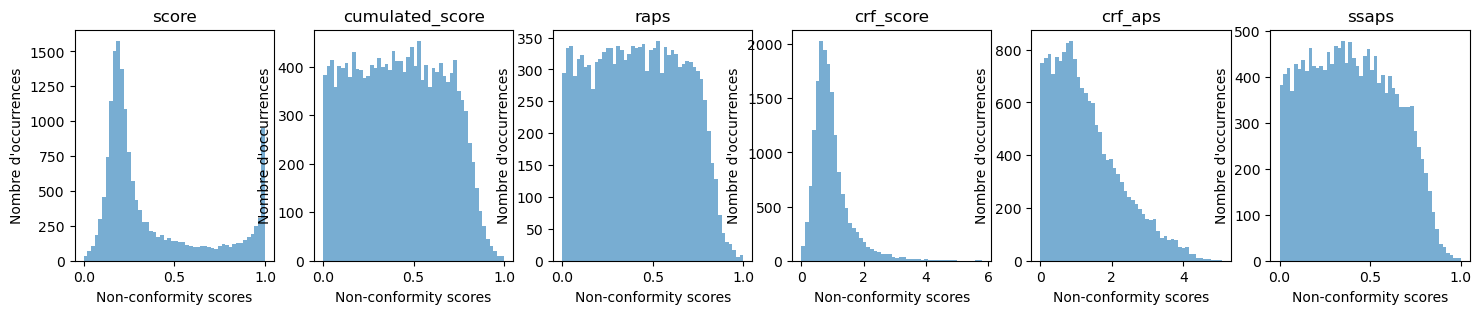

In [114]:
fig, axs = plt.subplots(1, len(method_params), figsize=(3 * len(method_params), 3))
for i, (method, predictions) in enumerate(y_pss.items()):
    axs[i].hist(cal_conformity_scores[method], bins=50, alpha=0.6, label=method)

    axs[i].set_xlabel("Non-conformity scores")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

We can notice that the SSAPS method is the only one using residuals that gives us non-conformity scores between 0 and 1.

# Conditional Coverage Metrics

In [115]:
for method_name, _ in method_params.items():
    print(f'Method: {method_name}')
    method_ssc = classification_ssc(y_test, y_pss[method_name][:, :, 0])
    filtered_ssc = method_ssc[method_ssc != 0.00]
    nan_indices = np.isnan(filtered_ssc)
    filtered_ssc = filtered_ssc[~nan_indices]
    min_ssc = min(filtered_ssc)
    max_ssc = max(filtered_ssc)
    print(f'Min SSC = {min_ssc:.2f} & Max SSC = {max_ssc:.2f}')
    print("=" * 50)

Method: score
Min SSC = 0.79 & Max SSC = 0.93
Method: cumulated_score
Min SSC = 0.80 & Max SSC = 1.00
Method: raps
Min SSC = 0.54 & Max SSC = 0.97
Method: crf_score
Min SSC = 0.67 & Max SSC = 1.00
Method: crf_aps
Min SSC = 0.50 & Max SSC = 1.00
Method: ssaps
Min SSC = 0.75 & Max SSC = 1.00


# Estimating the prediction sets

In [116]:
def count_null_set(y):
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count

In [117]:
nulls, coverages, accuracies, median_sizes, mean_sizes, variances = {}, {}, {}, {}, {}, {}

for method_name, (method, include_last_label) in method_params.items():
    accuracies[method_name] = accuracy_score(y_test, y_preds[method_name])
    nulls[method_name] = [
        count_null_set(y_pss[method_name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[method_name] = [
        classification_coverage_score(
            y_test, y_pss[method_name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    median_sizes[method_name] = [
        np.median(y_pss[method_name][:, :, i].sum(axis=1), axis=0) for i, _ in enumerate(alphas)
    ]
    mean_sizes[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]
    variances[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).std() for i, _ in enumerate(alphas)
    ]

In [118]:
nulls_90 = {k: int(v[0]) for k, v in nulls.items()}
coverages_90 = {k: v[0] for k, v in coverages.items()}
mean_sizes_90 = {k: v[0] for k, v in mean_sizes.items()}
median_sizes_90 = {k: v[0] for k, v in median_sizes.items()}
variances_90 = {k: v[0] for k, v in variances.items()}
names = ["Number of null sets", "Coverages", "Mean prediction set sizes", "Median prediction set sizes", "Standard deviation of PS sizes"]

In [119]:
summary_df = pd.DataFrame([nulls_90, coverages_90, mean_sizes_90, median_sizes_90, variances_90]).round(3)
summary_df.insert(0, '', names)
summary_df

,,score,cumulated_score,raps,crf_score,crf_aps,ssaps
0,Number of null sets,26.000,0.000,0.000,496.000,0.000,0.000
1,Coverages,0.898,0.958,0.934,0.901,0.991,0.966
2,Mean prediction set sizes,1.329,27.429,2.616,152.105,299.794,113.433
3,Median prediction set sizes,1.000,1.000,3.000,1.000,185.000,1.000
4,Standard deviation of PS sizes,0.615,68.677,0.783,357.773,323.964,224.999


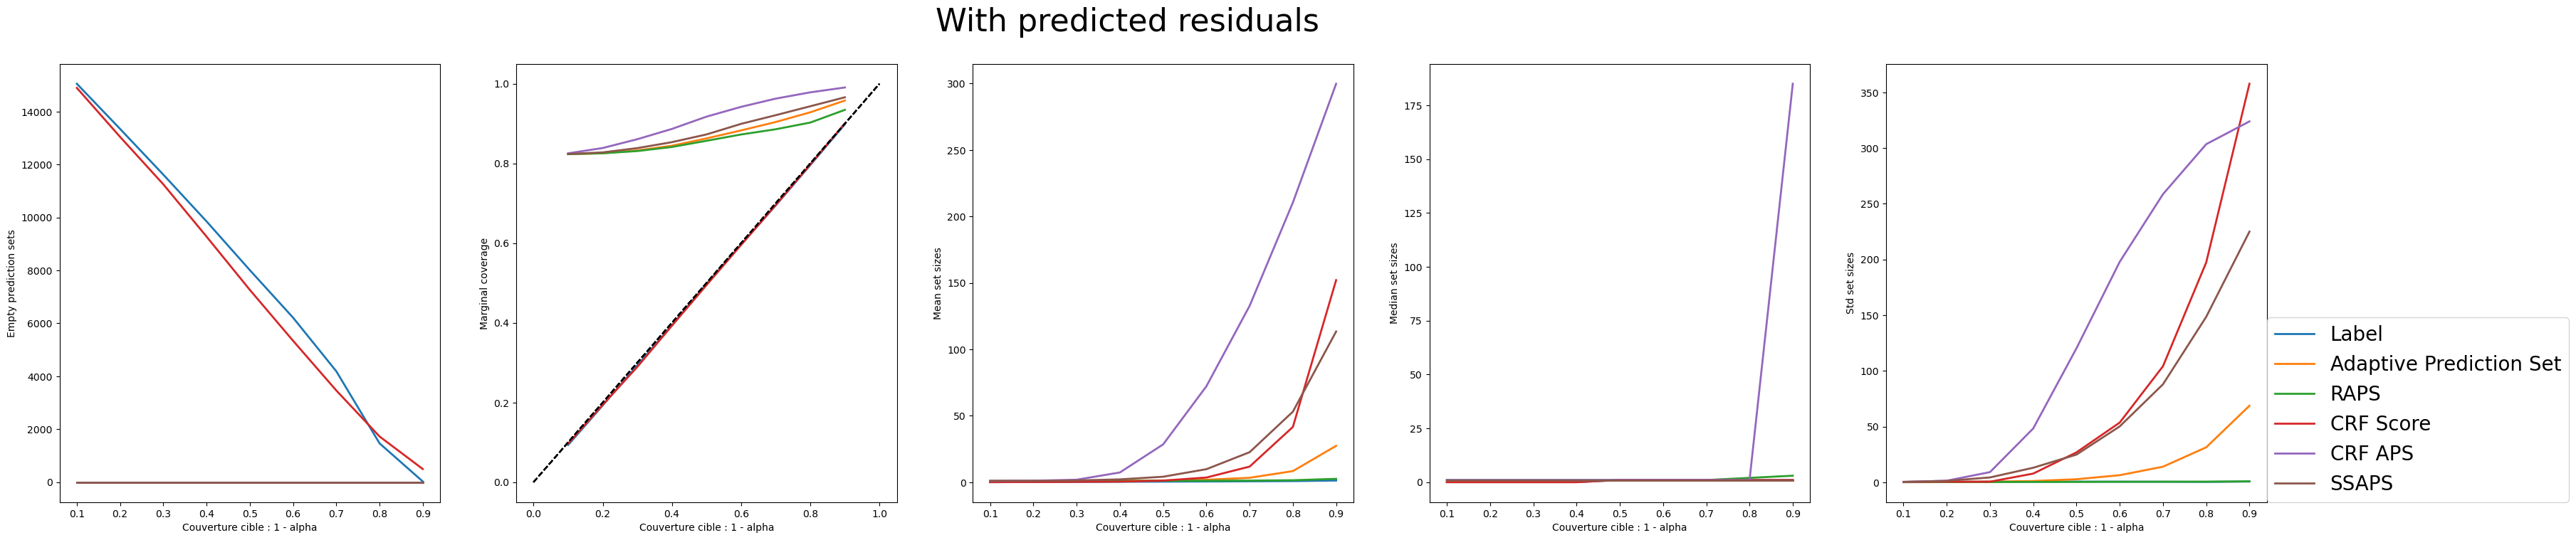

In [120]:
vars_y = [nulls, coverages, mean_sizes, median_sizes, variances]
label_mapping = {
    "score": "Label",
    "cumulated_score": "Adaptive Prediction Set",
    "raps": "RAPS",
    "crf_score": "CRF Score",
    "crf_aps": "CRF APS",
    "ssaps": "SSAPS"
}
labels_y = ["Empty prediction sets", "Marginal coverage", "Mean set sizes", "Median set sizes", "Std set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
fig.suptitle('With predicted residuals', fontsize=32)
for i, var in enumerate(vars_y):
    for name, (method, include_last_label) in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=label_mapping[name], linewidth=2)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

# CRF-APS Quantile

In [121]:
for name, (method, include_last_label)in method_params.items():
    print(f'Method: {name}')
    n = cal_conformity_scores[method].shape[0]
    quantile = np.quantile(np.squeeze(cal_conformity_scores[method]), ((n + 1) * (1 - 0.1)) / n)
    print(f'Quantile value is : {quantile:.3f}')
    print("=" * 50)

Method: score
Quantile value is : 0.923
Method: cumulated_score
Quantile value is : 0.752
Method: raps
Quantile value is : 0.752
Method: crf_score
Quantile value is : 1.687
Method: crf_aps
Quantile value is : 2.716
Method: ssaps
Quantile value is : 0.722


# Accuracy by prediction set size

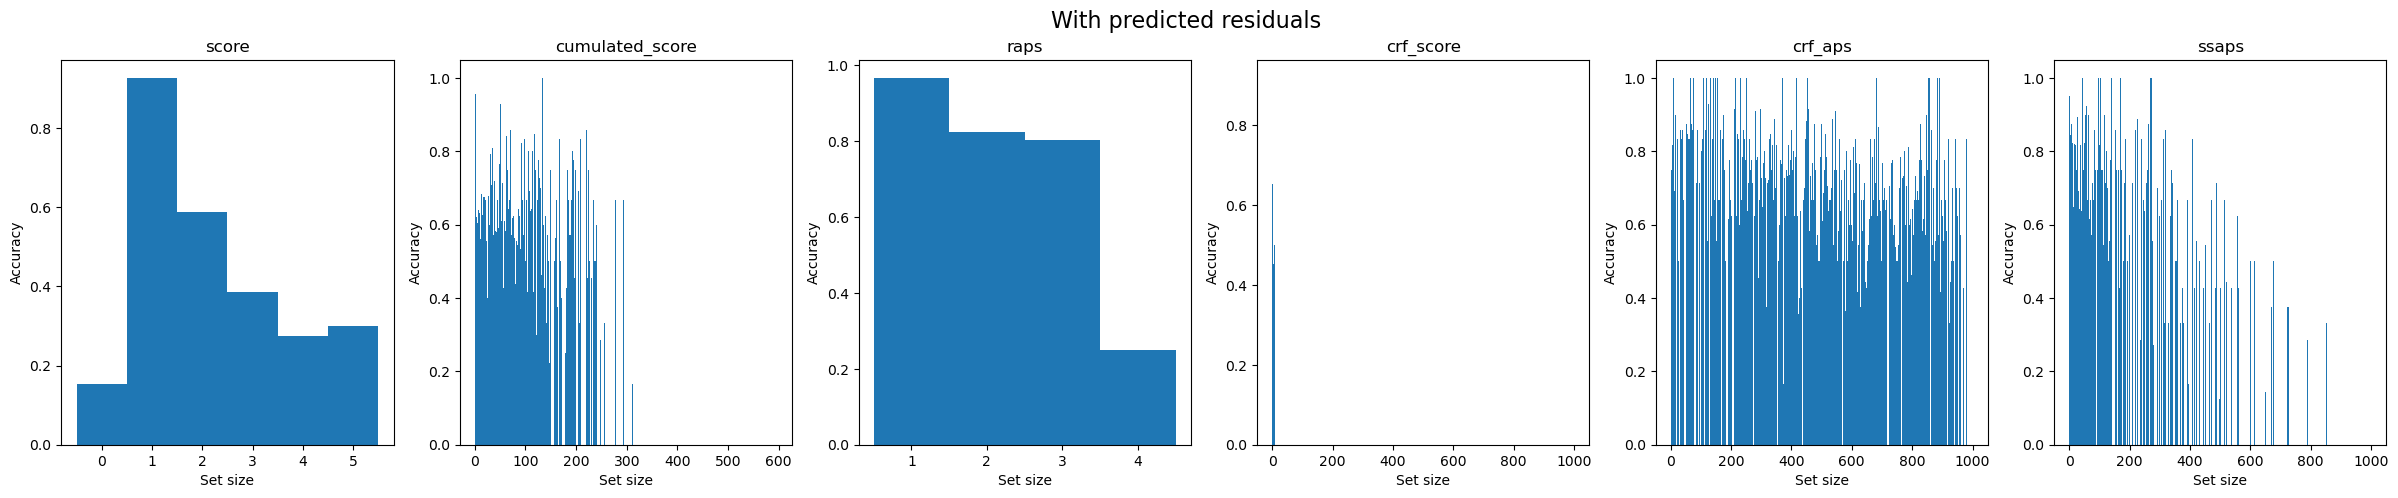

In [124]:
fig, axs = plt.subplots(1, len(method_params), figsize=(5*len(method_params), 5))
fig.suptitle('With predicted residuals', fontsize=16)
size_stratified_accuracy = {}

for i, (method, _) in enumerate(y_pss.items()):
    sizes = y_pss[method][:, :, 0].sum(axis=1)
    unique_sizes = np.unique(sizes)
    size_stratified_accuracy[method] = np.zeros(len(unique_sizes))
    for j, size in enumerate(unique_sizes):
        size_accuracy = []
        size_index = np.where(sizes == size)[0]
        if len(size_index) > 5:
            size_accuracy = accuracy_score(y_preds[method][size_index], np.array(y_test)[size_index])
            size_stratified_accuracy[method][j] = size_accuracy
    axs[i].bar(unique_sizes, size_stratified_accuracy[method], width=1)
    axs[i].set_xlabel("Set size")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_title(method)

# Distribution of prediction set sizes

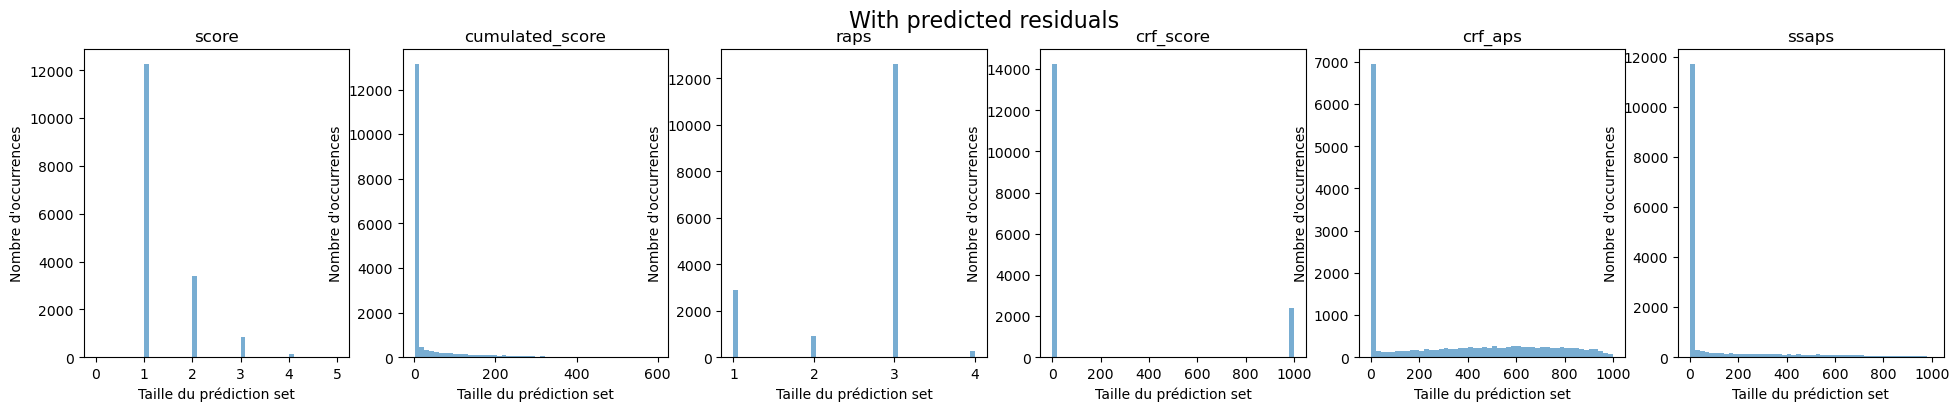

In [84]:
fig, axs = plt.subplots(1, len(method_params), figsize=(4*len(method_params), 4))
fig.suptitle('With predicted residuals', fontsize=16)

for i, (method, predictions) in enumerate(y_pss.items()):
    pss = predictions[:, :, 0].sum(axis=1)
    axs[i].hist(pss, bins=50, alpha=0.6, label=method)

    axs[i].set_xlabel("Taille du prédiction set")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

# Results if we manage to get the perfect residuals estimator

From now on, we won't use crf_score and crf_aps for the predictions.

In [126]:
method_params = {
    "score": ("score", True),
    "cumulated_score": ("cumulated_score", True),
    "raps": ("raps", True),
    "ssaps": ("ssaps", True)
}

In [127]:
alphas = np.arange(0.1, 1, .1)
mapie_model = MapieWrapper()
y_preds, y_pss, cal_conformity_scores, cal_residuals, quantiles = {}, {}, {}, {}, {}
for method_name, (method, include_last_label) in method_params.items():
    print("=" * 50)
    print(f'Method: {method_name}')
    mapie = MapieClassifier(mapie_model, method=method, cv="prefit", random_state=42)
    if method in ["crf_score", "ssaps", "crf_aps"]:
        ### Preds on calibration ###
        y_cal_res_pred = np.squeeze(get_residuals(y_res=y_cal, y_pred_proba=np.vstack(X_cal_res), method='crf_score'))
        
        ### Pred on test ###
        y_test_res_score_pred = np.squeeze(get_residuals(y_res=y_test, y_pred_proba=np.vstack(X_test_res), method='crf_score'))

        ### Fit on calibration set ###
        mapie.fit(X_cal, y_cal, residuals=y_cal_res_pred)

        cal_conformity_scores[method_name] = mapie.conformity_scores_
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            X_test,
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_score_pred
        )
        quantiles[method_name] = mapie.quantiles_

    else:   
        mapie.fit(X_cal, y_cal)
        y_preds[method_name], y_pss[method_name] = mapie.predict(X_test, alpha=alphas, include_last_label=include_last_label)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        quantiles[method_name] = mapie.quantiles_

Method: score
Method: cumulated_score
Method: raps
Method: ssaps


In [128]:
nulls, coverages, accuracies, median_sizes, mean_sizes, variances = {}, {}, {}, {}, {}, {}

for method_name, (method, include_last_label) in method_params.items():
    accuracies[method_name] = accuracy_score(y_test, y_preds[method_name])
    nulls[method_name] = [
        count_null_set(y_pss[method_name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[method_name] = [
        classification_coverage_score(
            y_test, y_pss[method_name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    median_sizes[method_name] = [
        np.median(y_pss[method_name][:, :, i].sum(axis=1), axis=0) for i, _ in enumerate(alphas)
    ]
    mean_sizes[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]
    variances[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).std() for i, _ in enumerate(alphas)
    ]

In [129]:
nulls_90 = {k: int(v[0]) for k, v in nulls.items()}
coverages_90 = {k: v[0] for k, v in coverages.items()}
mean_sizes_90 = {k: v[0] for k, v in mean_sizes.items()}
median_sizes_90 = {k: v[0] for k, v in median_sizes.items()}
variances_90 = {k: v[0] for k, v in variances.items()}
names = ["Number of null sets", "Coverages", "Mean prediction set sizes", "Median prediction set sizes", "Standard deviation of PS sizes"]

In [130]:
summary_df = pd.DataFrame([nulls_90, coverages_90, mean_sizes_90, median_sizes_90, variances_90]).round(3)
summary_df.insert(0, '', names)
summary_df

,,score,cumulated_score,raps,ssaps
0,Number of null sets,26.000,0.000,0.000,0.000
1,Coverages,0.898,0.958,0.934,0.963
2,Mean prediction set sizes,1.329,27.429,2.616,68.218
3,Median prediction set sizes,1.000,1.000,3.000,1.000
4,Standard deviation of PS sizes,0.615,68.677,0.783,138.447


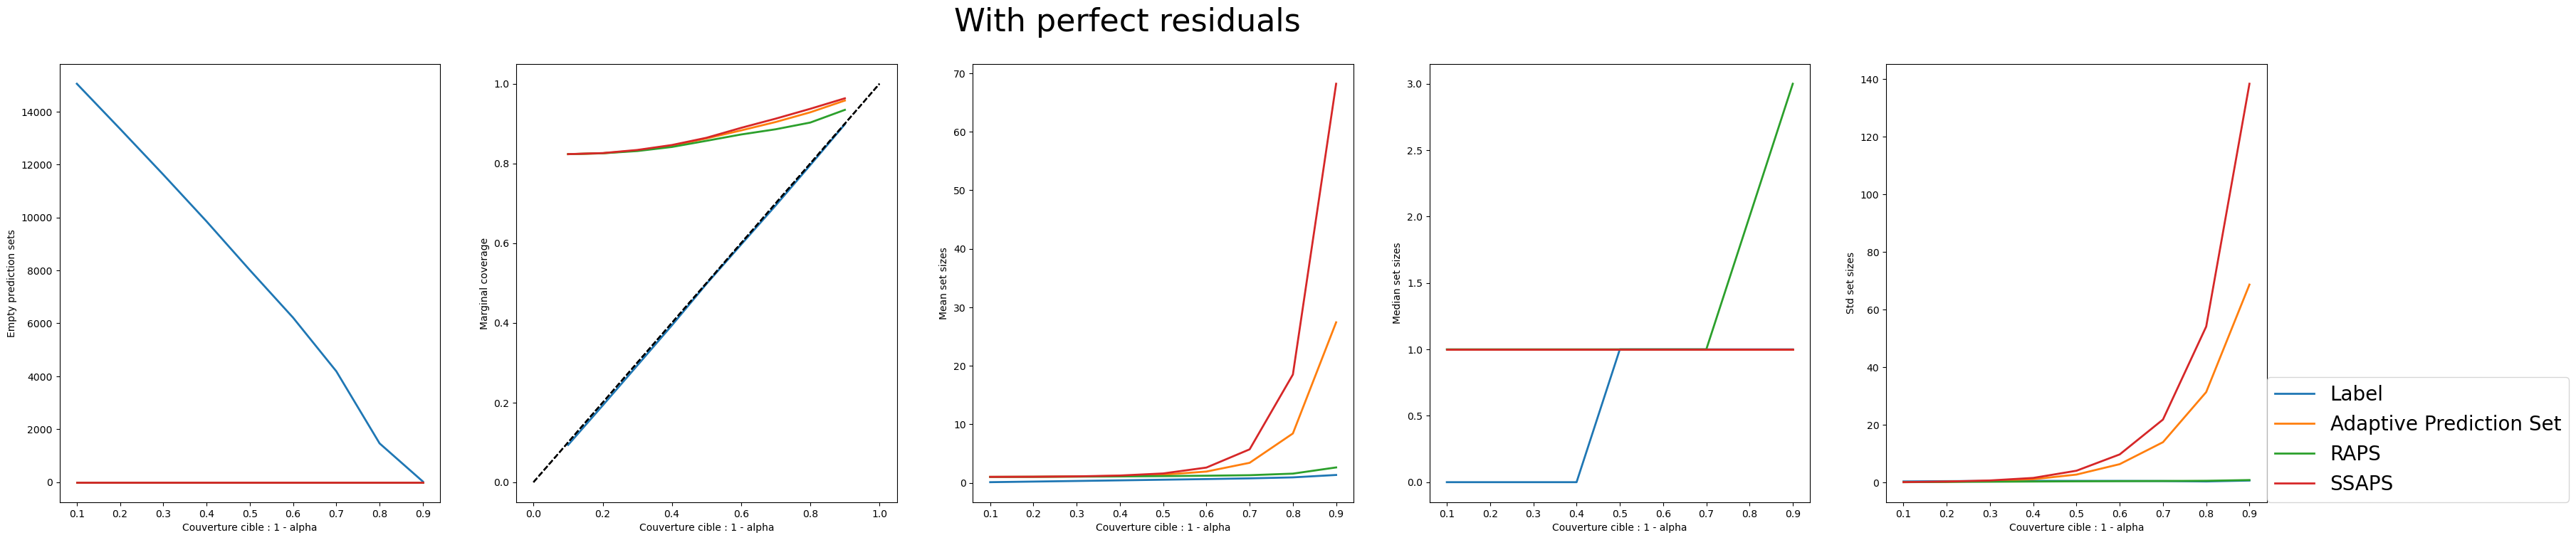

In [131]:
vars_y = [nulls, coverages, mean_sizes, median_sizes, variances]
label_mapping = {
    "score": "Label",
    "cumulated_score": "Adaptive Prediction Set",
    "raps": "RAPS",
    "ssaps": "SSAPS"
}
labels_y = ["Empty prediction sets", "Marginal coverage", "Mean set sizes", "Median set sizes", "Std set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
fig.suptitle('With perfect residuals', fontsize=32)
for i, var in enumerate(vars_y):
    for name, (method, include_last_label) in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=label_mapping[name], linewidth=2)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

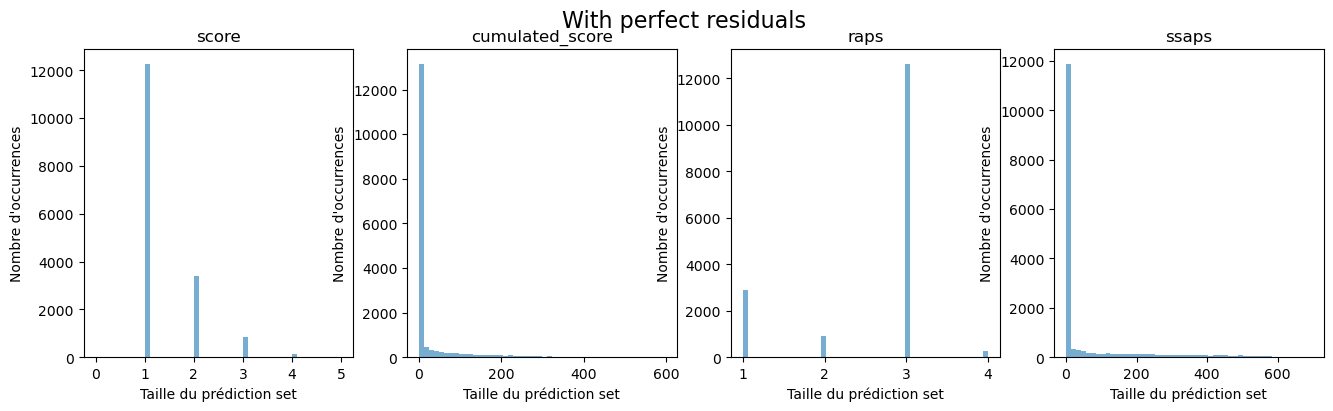

In [132]:
fig, axs = plt.subplots(1, len(method_params), figsize=(4*len(method_params), 4))
fig.suptitle('With perfect residuals', fontsize=16)

for i, (method, predictions) in enumerate(y_pss.items()):
    pss = predictions[:, :, 0].sum(axis=1)
    axs[i].hist(pss, bins=50, alpha=0.6, label=method)

    axs[i].set_xlabel("Taille du prédiction set")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

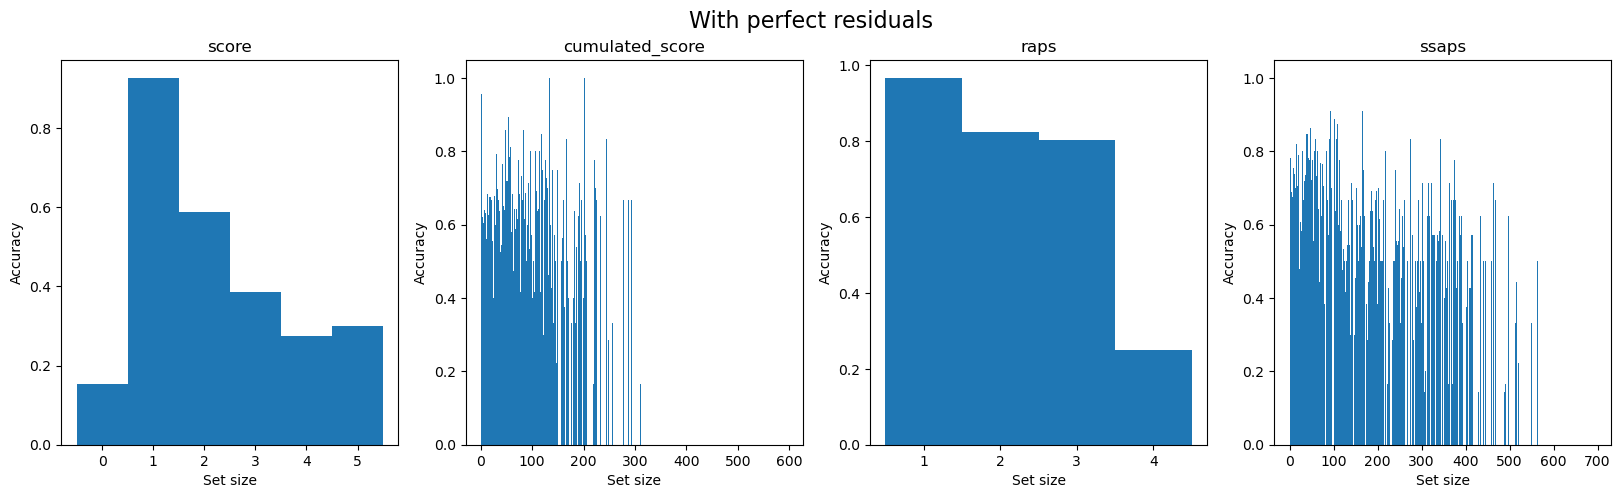

In [138]:
fig, axs = plt.subplots(1, len(method_params), figsize=(5*len(method_params), 5))
fig.suptitle('With perfect residuals', fontsize=16)
size_stratified_accuracy = {}

for i, (method, _) in enumerate(y_pss.items()):
    sizes = y_pss[method][:, :, 0].sum(axis=1)
    unique_sizes = np.unique(sizes)
    size_stratified_accuracy[method] = np.zeros(len(unique_sizes))
    for j, size in enumerate(unique_sizes):
        size_accuracy = []
        size_index = np.where(sizes == size)[0]
        if len(size_index) > 5:
            size_accuracy = accuracy_score(y_preds[method][size_index], np.array(y_test)[size_index])
            size_stratified_accuracy[method][j] = size_accuracy
    axs[i].bar(unique_sizes, size_stratified_accuracy[method], width=1)
    axs[i].set_xlabel("Set size")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_title(method)

In [50]:
for method_name, _ in method_params.items():
    print(f'Method: {method_name}')
    method_ssc = classification_ssc(y_test, y_pss[method_name][:, :, 0])
    filtered_ssc = method_ssc[method_ssc != 0.00]
    nan_indices = np.isnan(filtered_ssc)
    filtered_ssc = filtered_ssc[~nan_indices]
    min_ssc = min(filtered_ssc)
    max_ssc = max(filtered_ssc)
    print(f'Min SSC = {min_ssc:.2f} & Max SSC = {max_ssc:.2f}')
    print("=" * 50)

Method: score
Min SSC = 0.79 & Max SSC = 0.93
Method: cumulated_score
Min SSC = 0.80 & Max SSC = 1.00
Method: raps
Min SSC = 0.54 & Max SSC = 0.97
Method: ssaps
Min SSC = 0.75 & Max SSC = 1.00
